# Комп’ютерний практикум №3. Інтервальне прогнозування часових рядів за допомогою рекурентних нейроних мереж LSTM / GRU типу "кодувальник - декодувальник" Encoder-Decoder

In [76]:
import tensorflow as tf
import pandas as pd
from keras.models import Sequential
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
#from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.preprocessing import scale, MinMaxScaler
from math import sqrt
from numpy import split
from numpy import array
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM, GRU
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

## Завантажити часовий ряд з лабораторної роботи №2 згідно свого варіанту.

In [77]:
df = pd.read_csv('./Shanghai license plate price.csv', index_col=0)

In [78]:
df.head(5)

,Total number of license issued,lowest price,avg price,Total number of applicants
Date,,,,
Jan-02,1400,13600,14735,3718
Feb-02,1800,13100,14057,4590
Mar-02,2000,14300,14662,5190
Apr-02,2300,16000,16334,4806
May-02,2350,17800,18357,4665


In [79]:
scaler = MinMaxScaler()

# Fit and transform the data
normalized_data = scaler.fit_transform(df)

# Create a new DataFrame with the normalized data
df = pd.DataFrame(normalized_data, columns=df.columns)

df.isnull().any()

Total number of license issued    False
lowest price                      False
avg price                         False
Total number of applicants        False
dtype: bool

## Підготувати дані за необхідності: заповнити пропущені значення тощо

Будемо прогнозувати значення 'Close', видалимо зайві колонки

In [80]:
df = df.drop(['Total number of applicants'], axis=1)
df_1d = df.drop(['Total number of license issued', 'lowest price'], axis=1)


In [81]:
def split_dataset(data):
    split_index = int(len(data) * 0.75)

    # Split into standard weeks
    train, test = data[:split_index], data[split_index:]

    # Calculate the number of complete weeks in the train set
    num_train_weeks = len(train) // 7 * 7
    num_test_weeks = len(test) // 7 * 7

    # Adjust the train set to have an equal division
    train = train[:num_train_weeks]
    test = test[:num_test_weeks]

    # Restructure into windows of weekly data
    train = np.array(np.split(train, len(train) // 7))
    test = np.array(np.split(test, len(test) // 7))

    return train, test

In [82]:
train, test = split_dataset(df_1d.values)
# validate train data
print(train.shape)
print(train[0, 0, 0], train[-1, -1, 0])
# validate test
print(test.shape)
print(test[0, 0, 0], test[-1, -1, 0])

(21, 7, 1)
0.008530125938880001 0.7555829548456903
(7, 7, 1)
0.7495439276323239 0.9224236629216309


## Розглянути одновимірну модель

### LSTM / GRU з кількома скритими шарами для прогнозування часового ряду на 7 (сім) кроків вперед. Результатом буде вектор. v

#### Задати розмір вхідного вектору (гіперпараметр n_input) рівним, наприклад, 14 - це кількість попередніх точок/ днів, які використовуються в якості вхідних даних для моделі

In [83]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return np.array(X), np.array(y)

In [84]:
n_input = 7

#### Реалізувати власну функцію для побудови моделі та її навчання. Функцією втрат обрати MSE. Для навчання моделі обрати алгоритм Adam. Кількість епох навчання встановити рівною, наприклад, 20.

In [85]:
def build_model(train, n_input, LSTM_layer=True):
  # prepare data
  train_x, train_y = to_supervised(train, n_input)
  # define parameters
  verbose, epochs, batch_size = 0, 20, 16
  n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
  # define model
  model = Sequential()
  if LSTM_layer:
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
  else:
    model.add(GRU(200, activation='relu', input_shape=(n_timesteps, n_features)))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs))
  model.compile(loss='mse', optimizer='adam')
  # fit network
  model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
  return model

#### Реалізувати власну функцію для виконання прогнозів на основі навченої моделі на попередніх часових інтервалах.

In [86]:
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

In [87]:
def evaluate_model(train, test, n_input, LSTM_layer=True):
    # fit model
    model = build_model(train, n_input, LSTM_layer)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

#### Оцінити якість навчання моделі на перевірочній множині за RMSE, причому рахувати і загальне значення RMSE за всі 7 (сім) кроків вперед, і вектор значень RMSE за кожним кроком прогнозованого інтервалу, тобто вектор RMSE розмірності 7 (сім)

In [88]:
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    # plot forecasts vs observations
    for j in range(predicted.shape[1]):
        show_plot(actual[:, j], predicted[:, j], j + 1)
    return score, scores


def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))



#### Побудувати на одній координатній вісі графіки початкових y_original і спрогнозованих y_predicted значень цільової змінної. Таких графіків буде 7 (сім) - за кожним кроком прогнозованого інтервалу.  

In [89]:
def show_plot(true, pred, title):
    fig = pyplot.subplots()
    pyplot.plot(true, label='Y_original')
    pyplot.plot(pred, dashes=[4, 3], label='Y_predicted')
    pyplot.xlabel('N_samples', fontsize=12)
    pyplot.ylabel('AVG Value', fontsize=12)
    pyplot.title(title, fontsize=12)
    pyplot.grid(True)
    pyplot.legend(loc='upper right')
    pyplot.show()

#### LSTM model

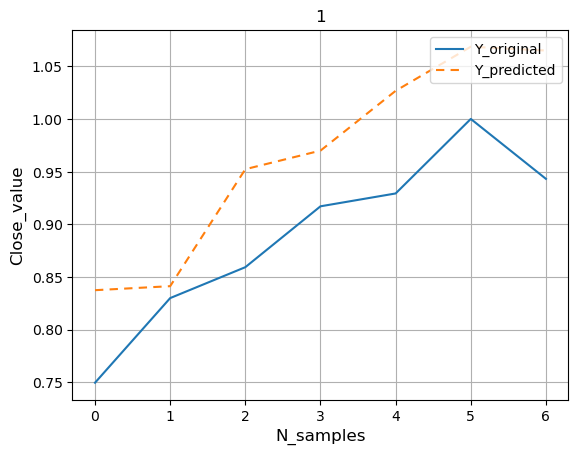

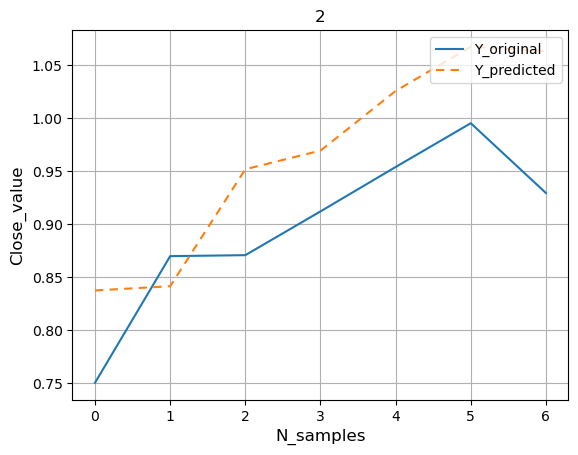

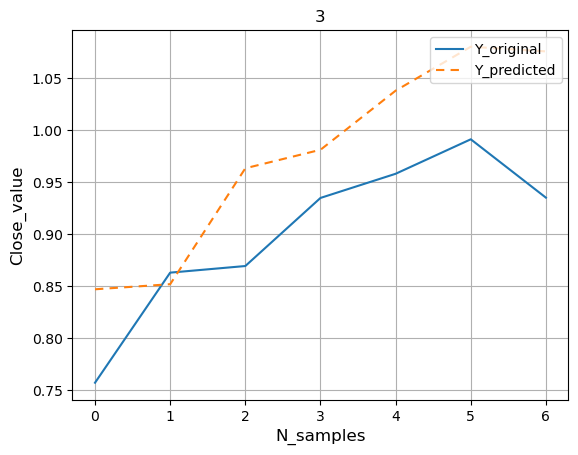

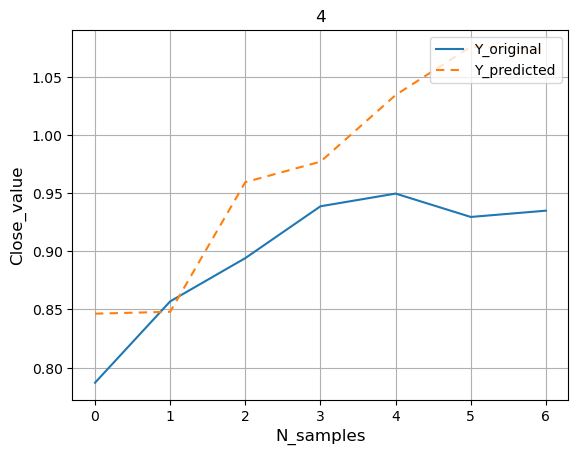

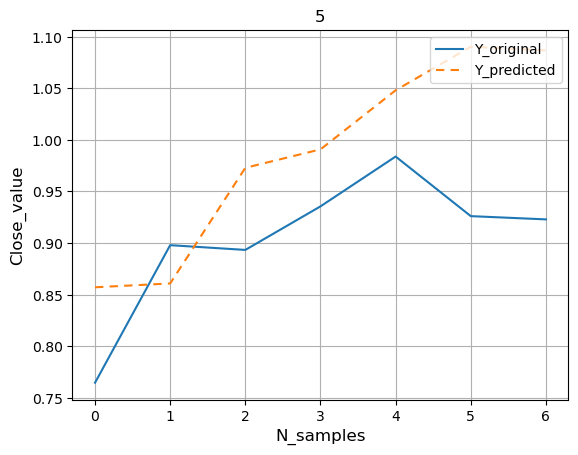

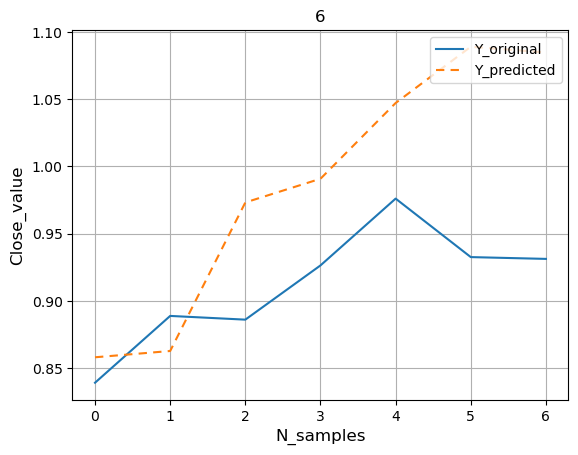

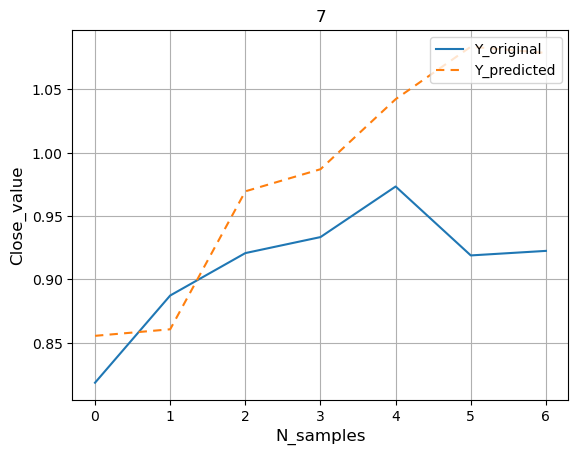

lstm: [0.092] 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1


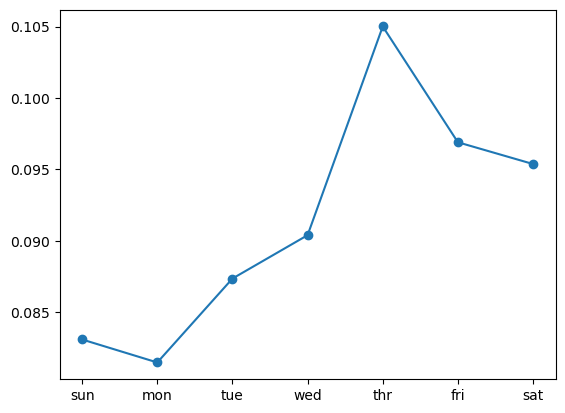

In [90]:
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
fig = pyplot.subplots()
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

#### GRU model

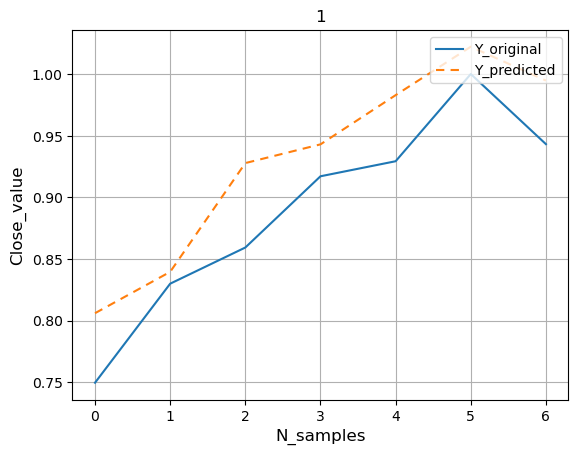

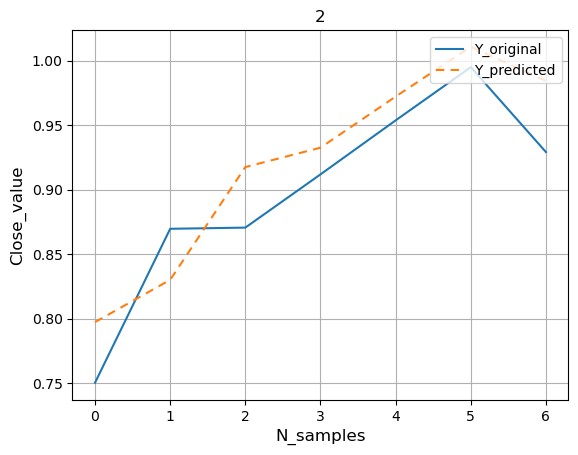

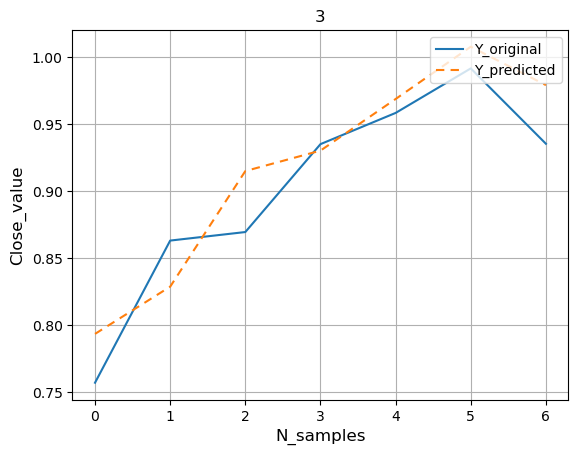

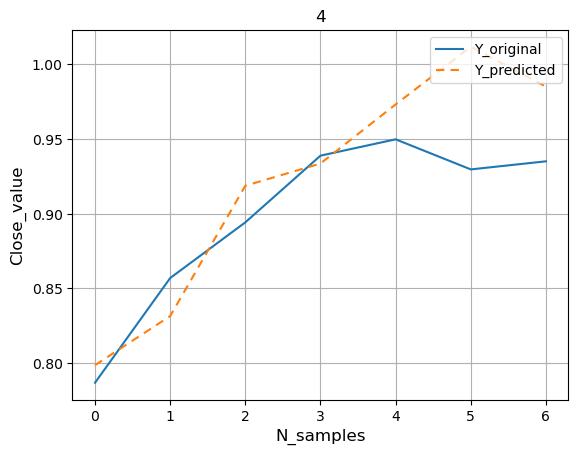

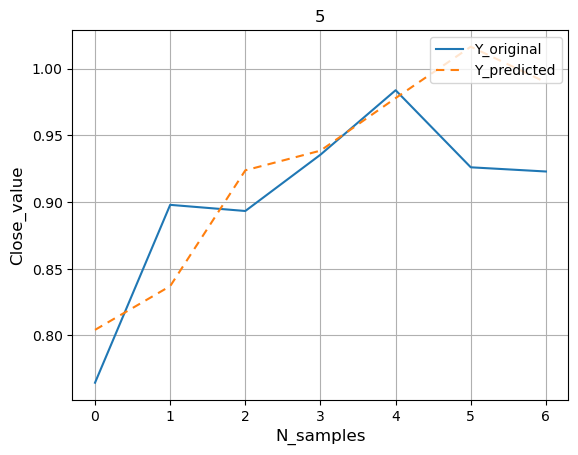

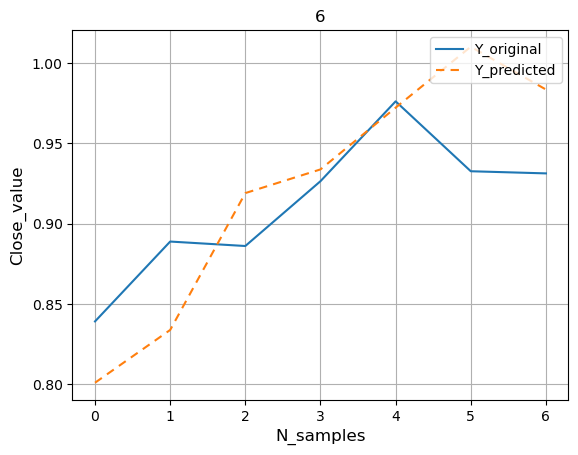

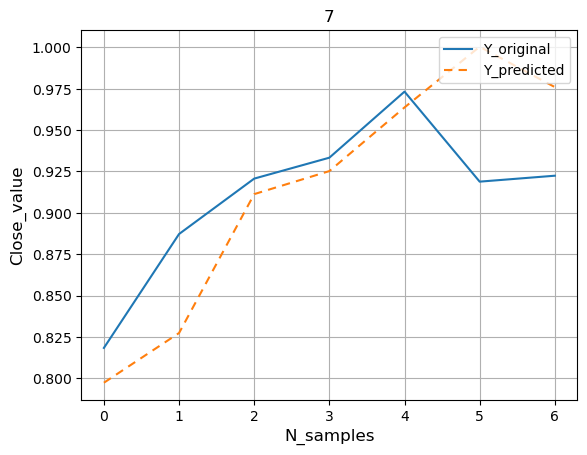

GRU: [0.043] 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0


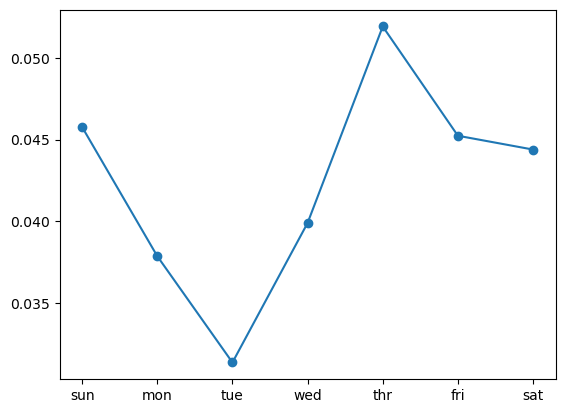

In [91]:
score, scores = evaluate_model(train, test, n_input, LSTM_layer=False)
# summarize scores
summarize_scores('GRU', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
fig = pyplot.subplots()
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

#### Які дні краще справляються з прогнозом ?
З графіків видно, що обидві моделі дають найкращий результат у четвер

#### Дослідити, яку кількість попередніх кроків/ днів краще використати в якості вхідних даних (гіперпараметр n_input).  Для цього дослідити кілька моделей з різними значеннями n_input - розміру вхідного вектору. Наприклад, попередні три дні, сім днів, 21 день, 30 днів і більше.

##### n_input = 3

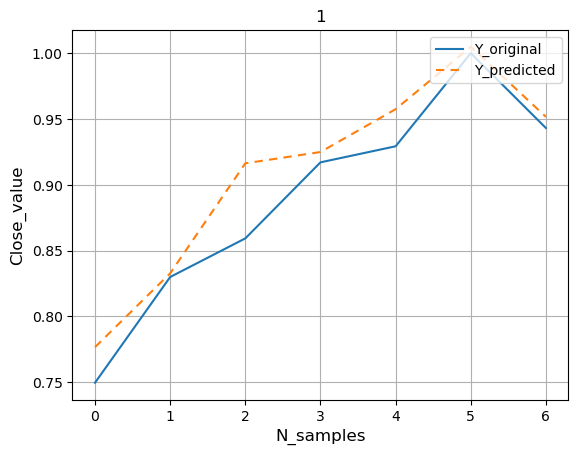

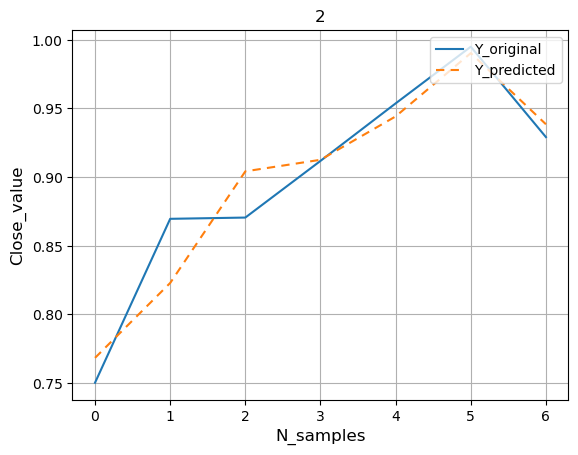

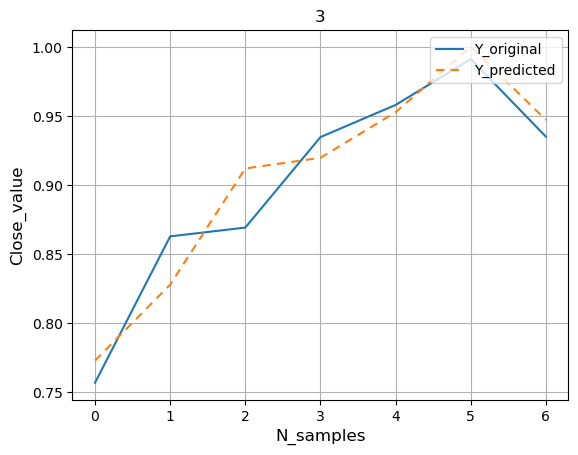

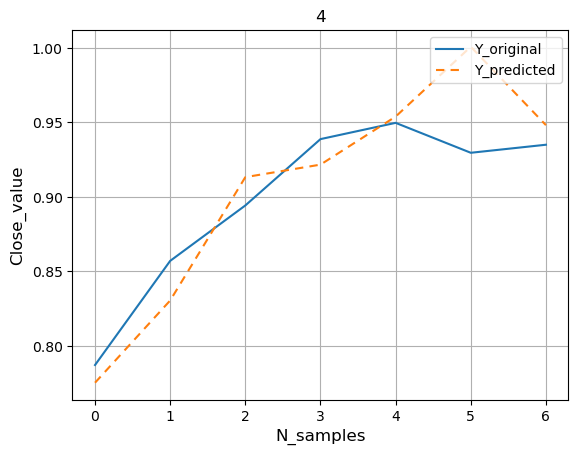

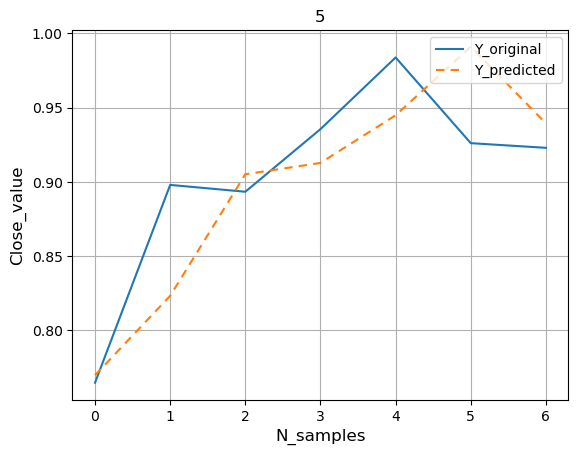

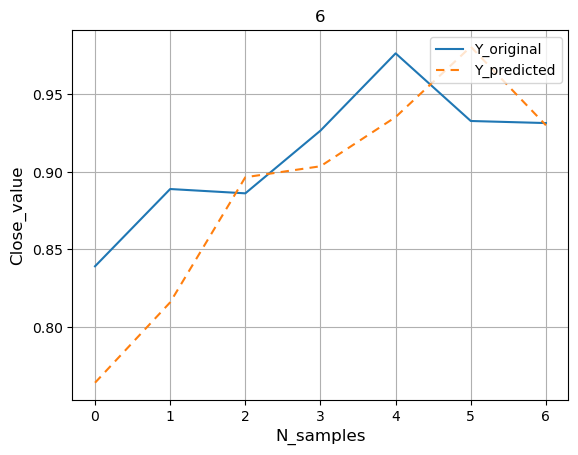

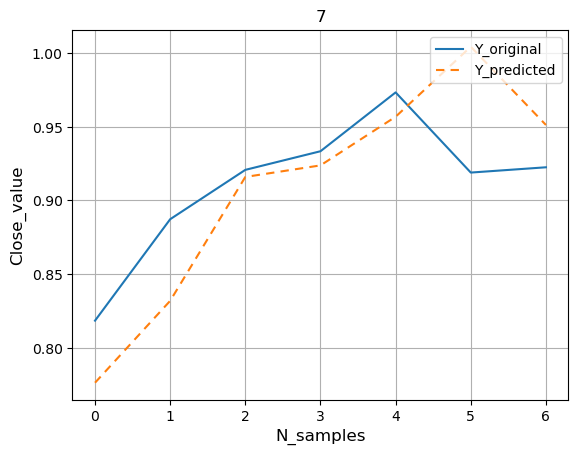

GRU: [0.035] 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0


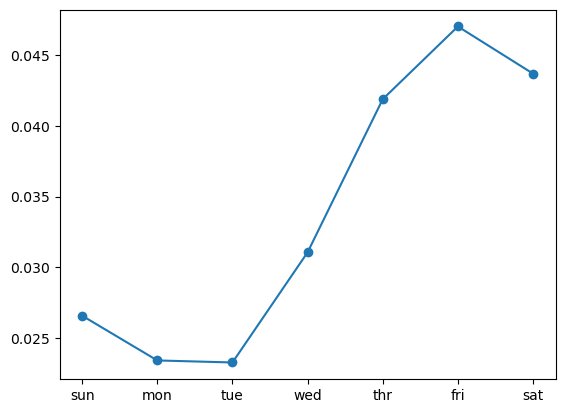

In [92]:
n_input = 3
score, scores = evaluate_model(train, test, n_input, LSTM_layer=False)
# summarize scores
summarize_scores('GRU', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
fig = pyplot.subplots()
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

##### n_input = 21

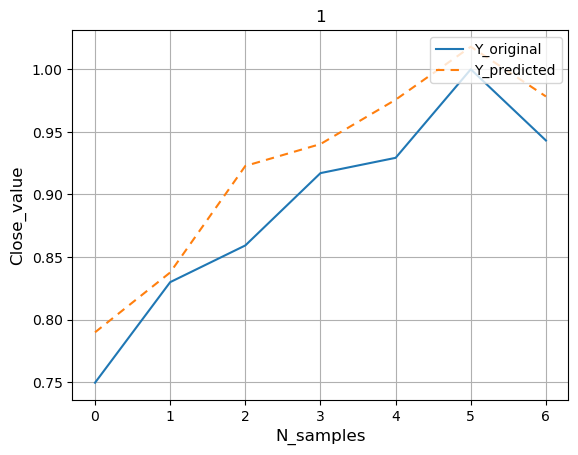

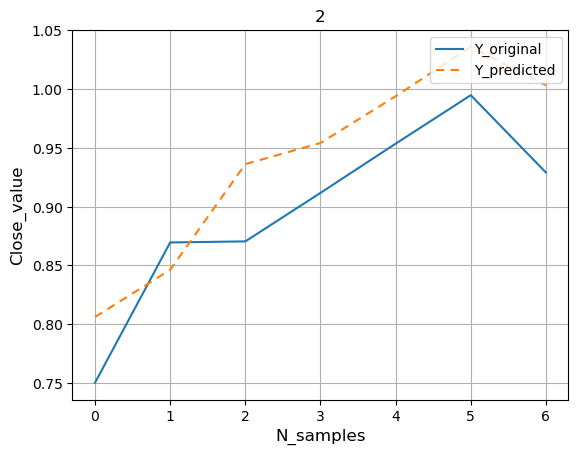

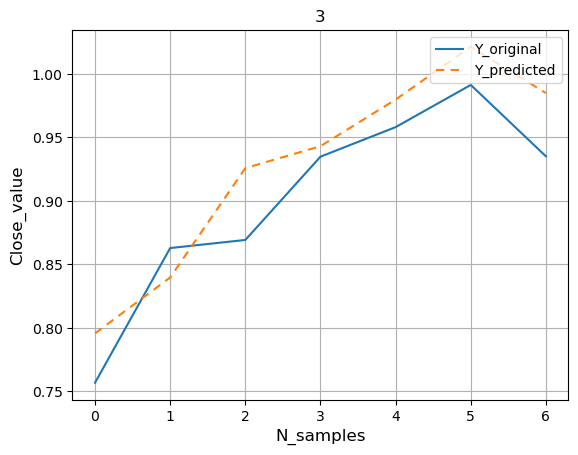

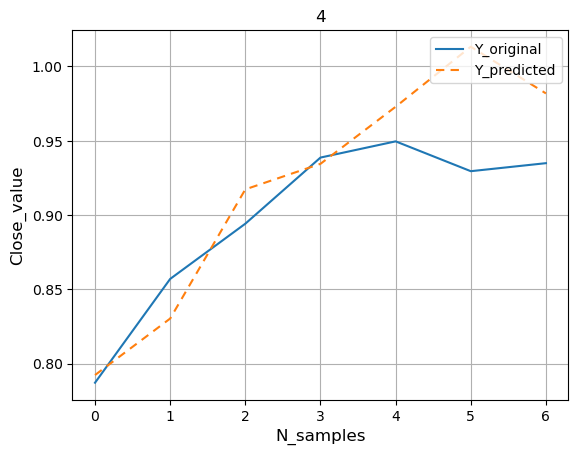

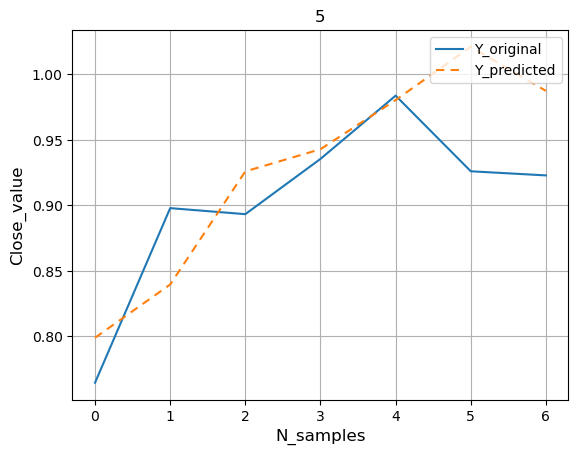

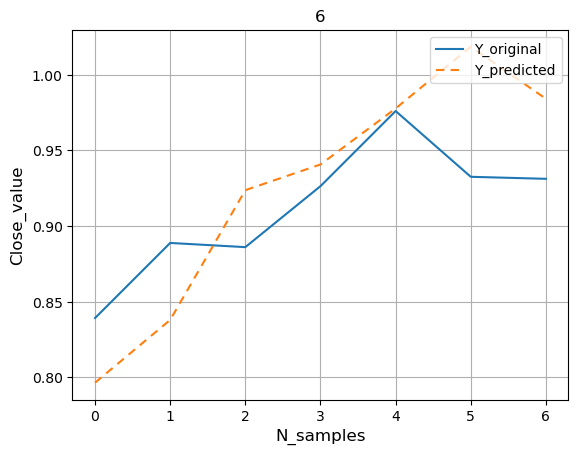

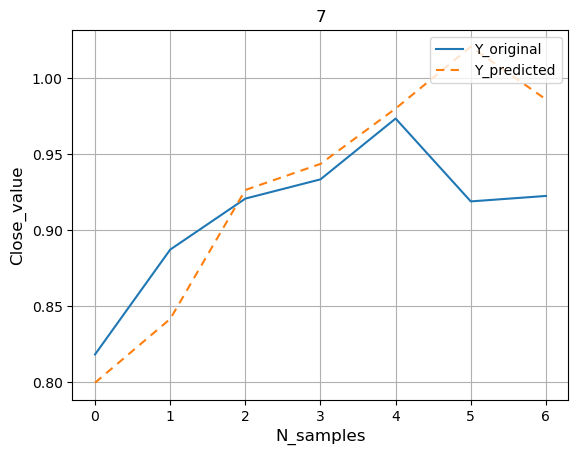

GRU: [0.045] 0.0, 0.1, 0.0, 0.0, 0.1, 0.0, 0.0


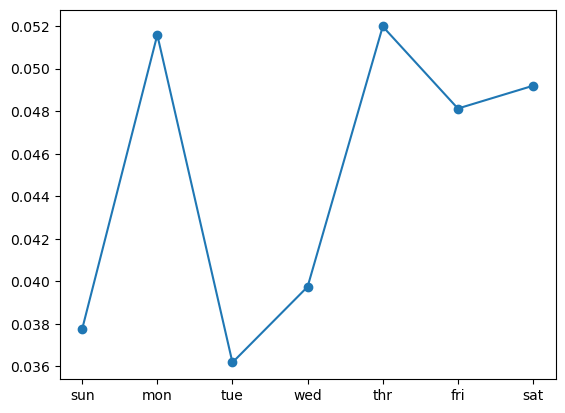

In [93]:
n_input = 21
score, scores = evaluate_model(train, test, n_input, LSTM_layer=False)
# summarize scores
summarize_scores('GRU', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
fig = pyplot.subplots()
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

##### n_input = 30

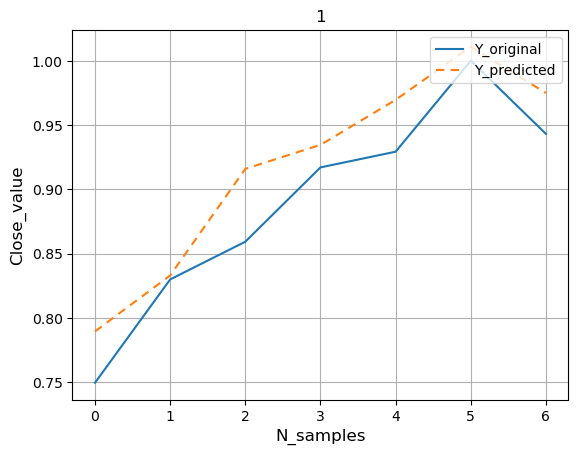

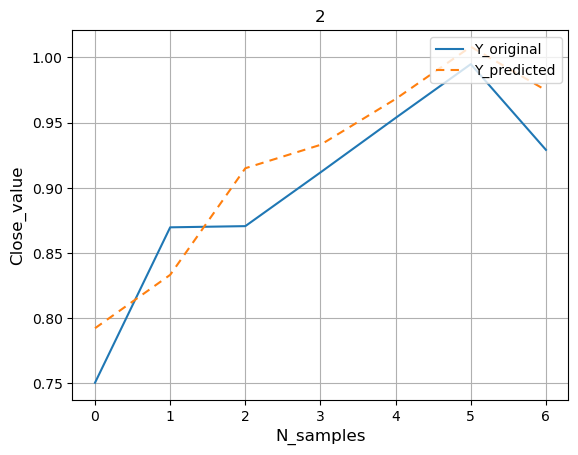

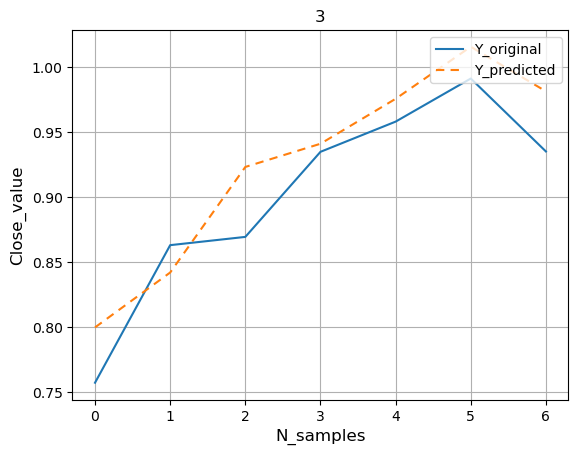

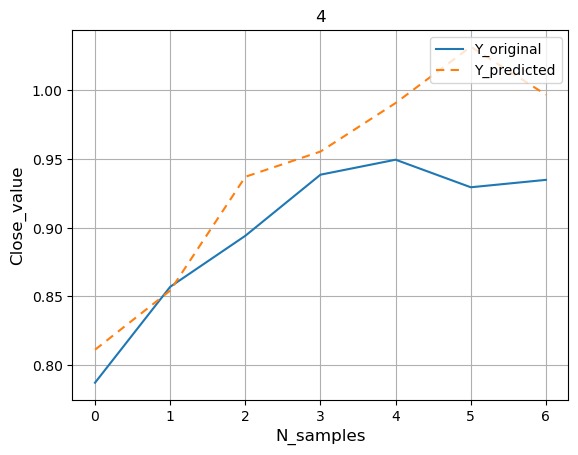

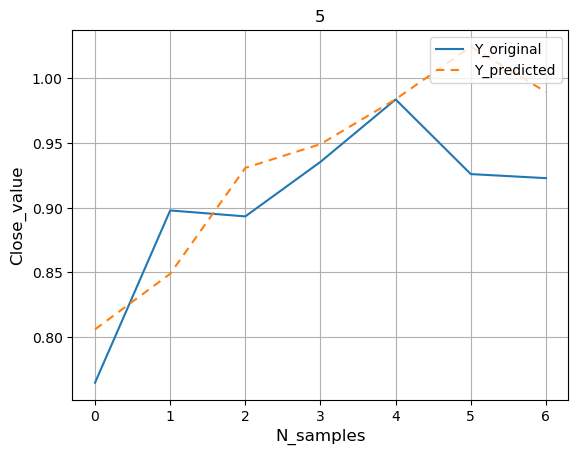

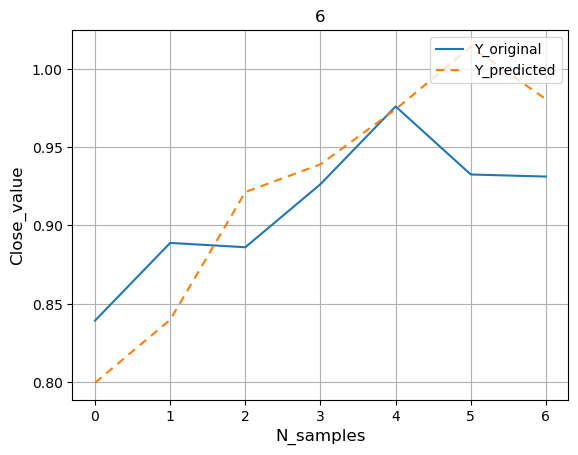

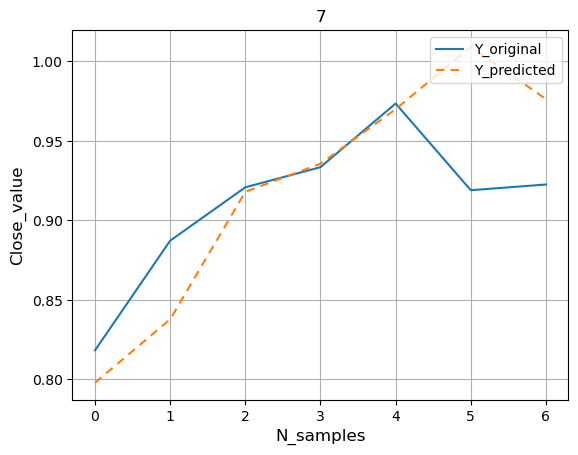

GRU: [0.043] 0.0, 0.0, 0.0, 0.1, 0.1, 0.0, 0.0


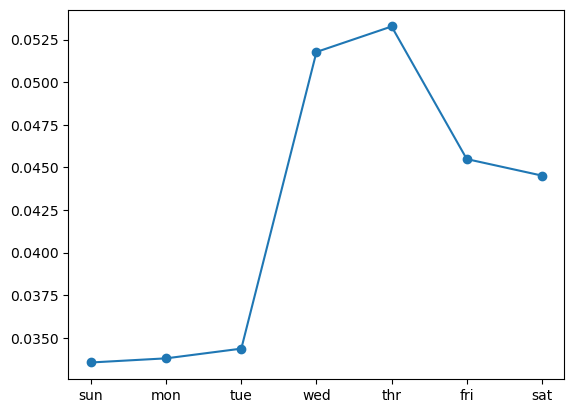

In [94]:
n_input = 30
score, scores = evaluate_model(train, test, n_input, LSTM_layer=False)
# summarize scores
summarize_scores('GRU', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
fig = pyplot.subplots()
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

- Дослідити, яку кількість попередніх кроків/ днів краще використати в якості вхідних даних

За результатом, найкраще ставити 30 днів, але похибка дуже повільно зменьшується при зміні значення n_input від 3 до 30, тому я вважаю, що цей параметр не сильно впливає на точність
- Яка з моделей LSTM чи GRU працює краще ?

Модель GRU працює краще, ніж LSTM в більшості випадків

### LSTM / GRU типу "кодувальник - декодувальник" Encoder-Decoder:

- Обрати розмір вхідного вектору.


- Задати шар, який буде виконувати кодування. Можна реалізувати глибокий кодувальник.


- Задати вихідний шар, який прогнозує один крок у вихідній послідовності.


- Використати обгорнуті повнозв'язні шари (оболонку TimeDistributed). 


- Порівняти з альтернативним рішенням - згладжуванням всієї структури, що створена декодувальником, і пряме виведення вектора.


- Оцінити якість навчання моделі / моделей на перевірочній множині за RMSE: рахувати і загальне значення RMSE за всі 7 (сім) кроків вперед, і вектор значень RMSE за кожним кроком прогнозованого інтервалу, тобто вектор RMSE розмірності 7 (сім). 


- Побудувати на одній координатній вісі графіки початкових y_original і спрогнозованих y_predicted значень цільової змінної.  Зробити висновки щодо якості наданих прогнозів.

In [95]:
def build_autoencode_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 20, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(200, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

def evaluate_autoencode_model(train, test, n_input):
  # fit model
  model = build_autoencode_model(train, n_input)
  # history is a list of weekly data
  history = [x for x in train]
  # walk-forward validation over each week
  predictions = list()
  for i in range(len(test)):
      # predict the week
      yhat_sequence = forecast(model, history, n_input)
      # store the predictions
      predictions.append(yhat_sequence)
      # get real observation and add to history for predicting the next week
      history.append(test[i, :])
  # evaluate predictions days for each week
  predictions = array(predictions)
  score, scores = evaluate_forecasts(test[:, :, 0], predictions)
  return score, scores

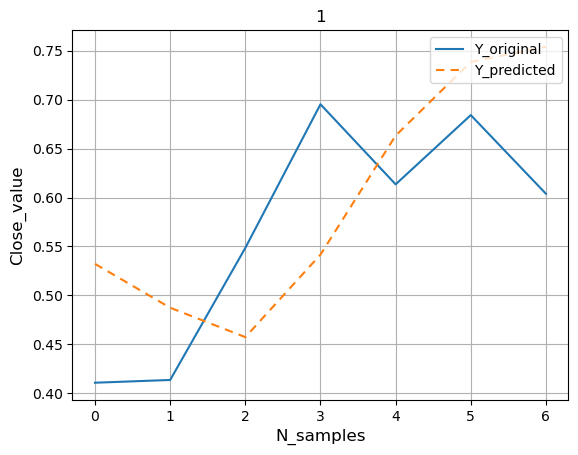

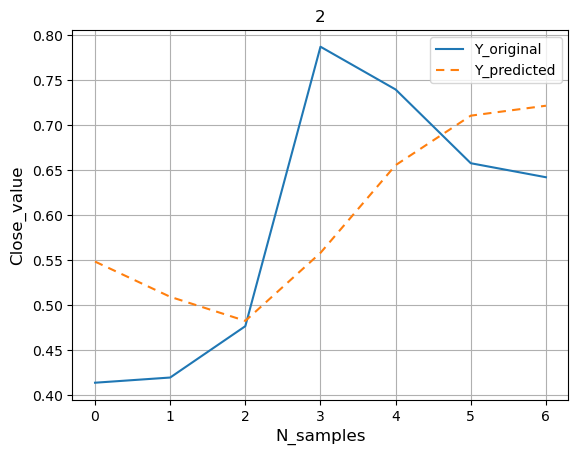

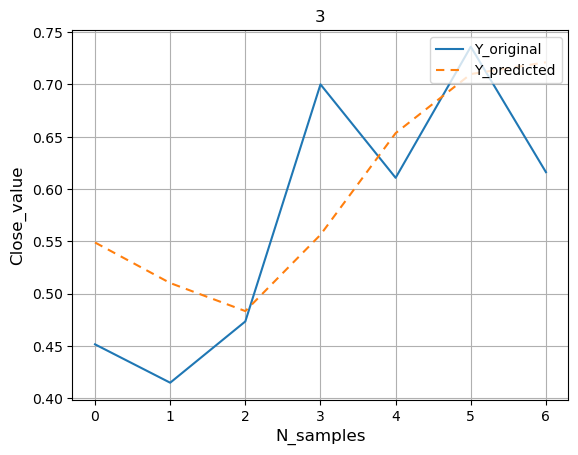

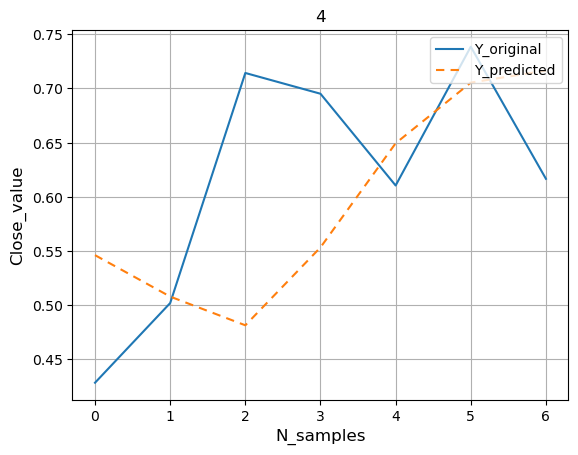

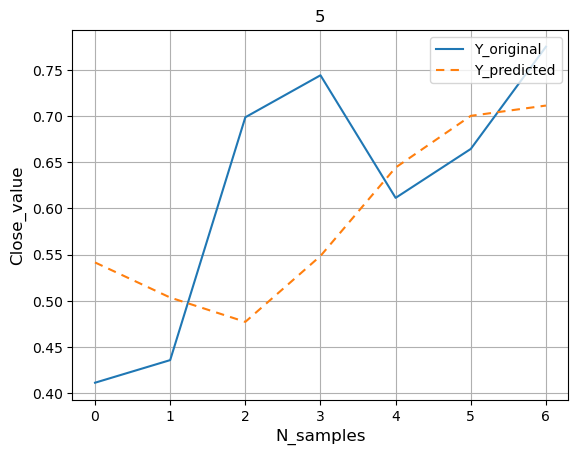

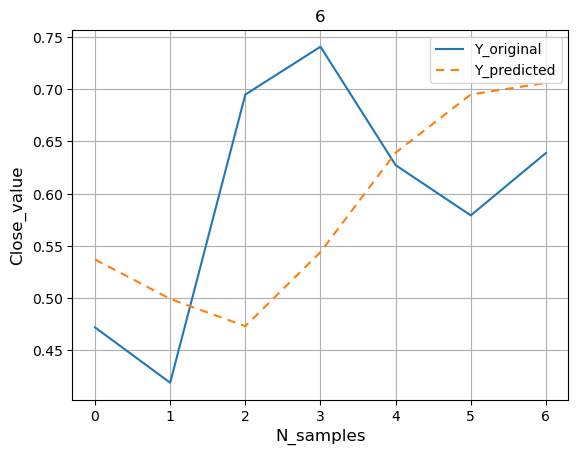

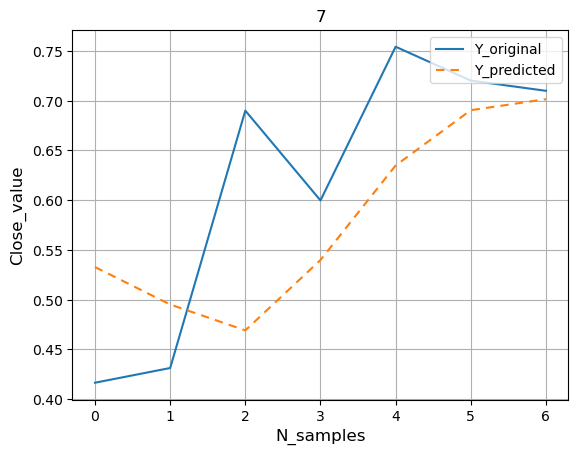

lstm: [0.115] 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1


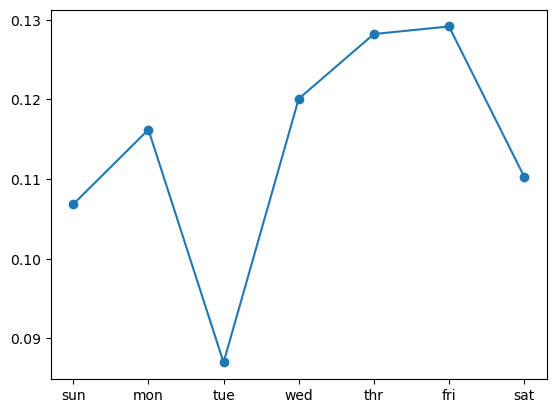

In [99]:
n_input = 14
score, scores = evaluate_autoencode_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

Отже, модель автокодувальник дає значно гірший прогноз на цьому наборі даних, аніж звичайна LSTM з кількома скритими шарами

## LSTM / GRU типу "кодувальник - декодувальник" на основі багатовимірних даних

- Підготувати навчальні дані, включивши до них всі наявні ознаки.


- Оновити функцію, яка використовується для виконання прогнозів на основі навченої моделі, щоб використовувати всі наявні ознаки на попередніх часових інтервалах.


- Використати ті ж самі архітектури та конфігурації моделей, що і в п.4.


- Збільшити кількість епох для навчання, наприклад, до 50.


- Оцінити якість навчання моделі на перевірочній множині за RMSE: рахувати і загальне значення RMSE за всі 7 (сім) кроків вперед, і вектор значень RMSE за кожним кроком прогнозованого інтервалу, тобто вектор RMSE розмірності 7 (сім). 


- Чи є дана модель на основі багатовимірних вхідних даних більш стабільною порівняно з одномірною моделлю?

In [97]:
def evaluate_forecasts_n_dim(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores_n_dim(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised_n_dim(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

# train the model
def build_model_n_dim(train, n_input):
	# prepare data
	train_x, train_y = to_supervised_n_dim(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 50, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(200, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

# make a forecast
def forecast_n_dim(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into [1, n_input, n]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model_n_dim(train, test, n_input):
	# fit model
	model = build_model_n_dim(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast_n_dim(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

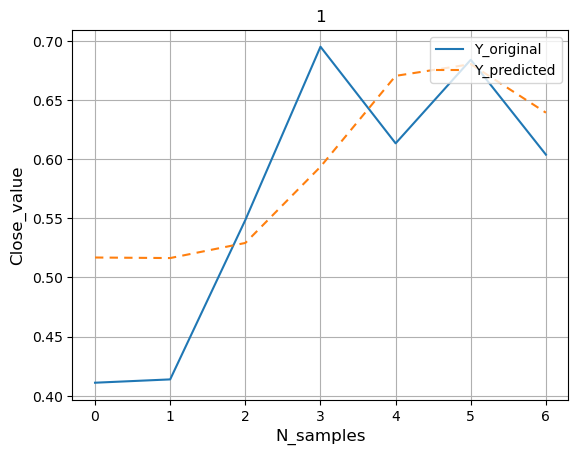

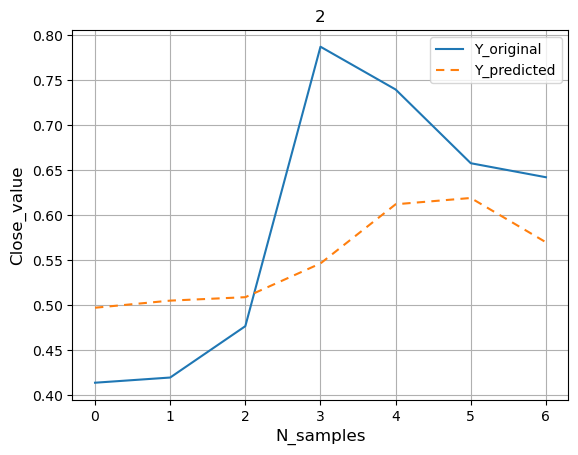

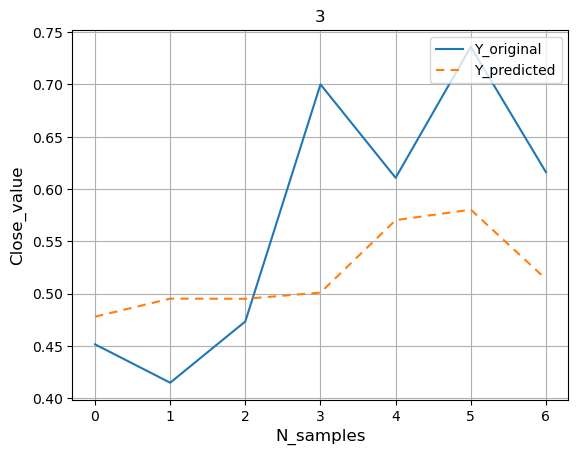

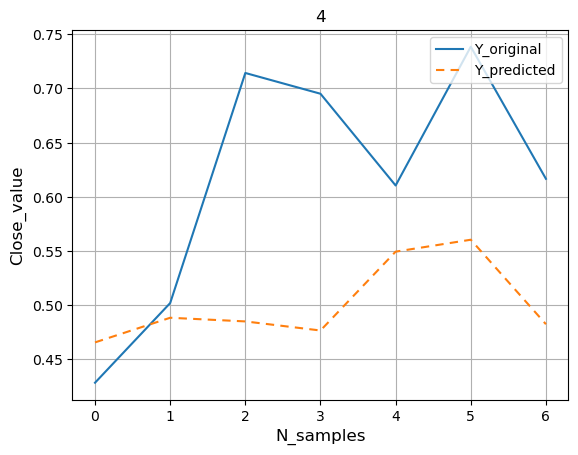

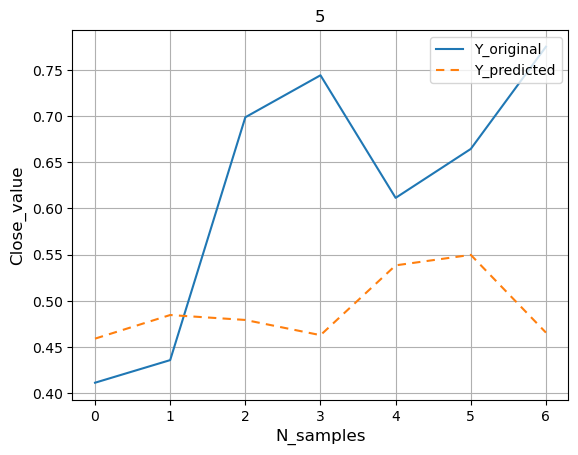

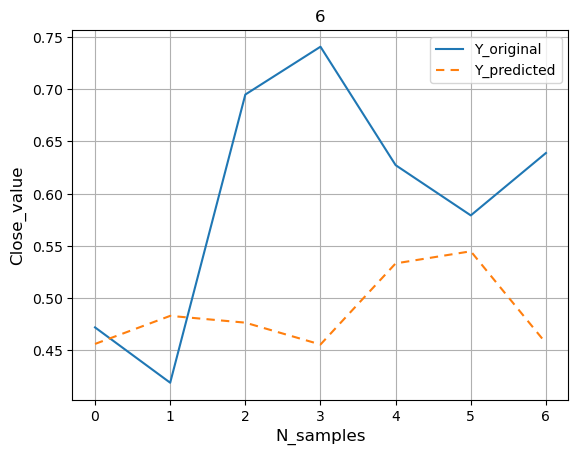

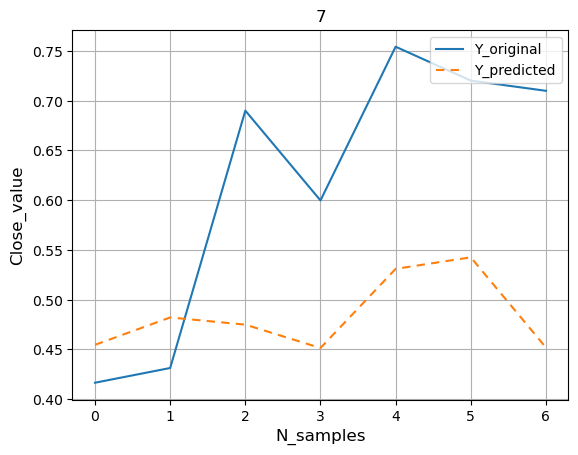

lstm: [0.144] 0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2


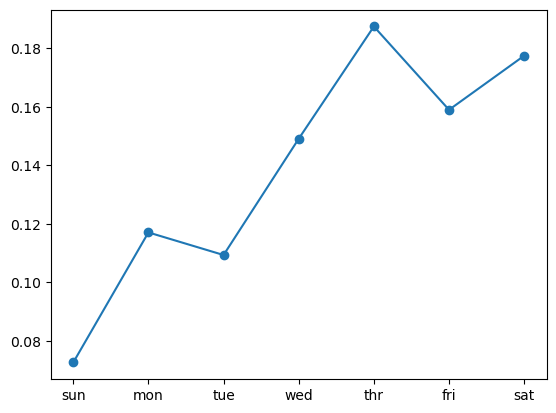

In [98]:
# split into train and test
train, test = split_dataset(df.values)
# evaluate model and get scores
n_input = 14
score, scores = evaluate_model_n_dim(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

Отже, модель на основі багатовимірних даних є більш стабільною за одновимірну, за показником RMSE.